In [1]:
import noise_calc
import prop_simulate
import prop_design
import optimization_NSGA2
# import xfoil_interface
import numpy as np
import matplotlib.pyplot as plt
import time
import math
import pandas as pd

In [2]:
Diameter_m = 3;
SpinnerCutoff = 0.2
NumberOfBlades = 2
ObjectiveThrust_N = 4000
AxialVelocity_m_s = 0
ForwardVelocity_m_s = 0
ClPolars = pd.read_table("ClarkYAutoClPolar4.dat")
CdPolars = pd.read_table("ClarkYAutoCdPolar4.dat")
NumberOfStations = 11
Convergence = 0.001 #Newton

DistanceToObserver_m = 150
AngleToObserver_deg = 30    #Angle from Negative thrust to observer

SoundSpeed_m_s = 343
AirDensity_Kg_m3 = 1.225

In [3]:
def Evaluation(Chromossome):

    Croot_adim = Chromossome["Croot"]
    Cmax_adim = Chromossome["Cmax"]
    Smax_adim = Chromossome["Smax"]
    Ctip_adim = Chromossome["Ctip"]
    Pitch_m = Chromossome["Pitch"]
    Colective_deg = Chromossome["Collective"]

    #c_R = (a*r**3 + b*r**2 + c*r + d)**0.5
    a = -(2*Cmax_adim**2*Smax_adim - Cmax_adim**2 + Croot_adim**2*Smax_adim**2 - 2*Croot_adim**2*Smax_adim + Croot_adim**2 - Ctip_adim**2*Smax_adim**2)/(Smax_adim**2*(Smax_adim - 1)**2)
    b = -(- 3*Cmax_adim**2*Smax_adim**2 + Cmax_adim**2 - 2*Croot_adim**2*Smax_adim**3 + 3*Croot_adim**2*Smax_adim**2 - Croot_adim**2 + 2*Ctip_adim**2*Smax_adim**3)/(Smax_adim**2*(Smax_adim - 1)**2)
    c = -(3*Cmax_adim**2*Smax_adim - 2*Cmax_adim**2 + Croot_adim**2*Smax_adim**3 - 3*Croot_adim**2*Smax_adim + 2*Croot_adim**2 - Ctip_adim**2*Smax_adim**3)/(Smax_adim*(Smax_adim - 1)**2)
    d = Croot_adim**2

    S = np.linspace(0, 0.9999, NumberOfStations, endpoint = True)
    RadialStations_adim = [SpinnerCutoff + ((1 - SpinnerCutoff)*s) for s in S]
    RadialStations_m = [r*Diameter_m/2 for r in RadialStations_adim]

    ChordDistribution_m = [((a*s**3 + b*s**2 + c*s + d)**0.5)*Diameter_m/2 for s in S]

    TwistDistribution_deg = prop_design.simple_pitch(RadialStations_m, Pitch_m)
    TwistDistributionCollective_deg = [twist + Colective_deg for twist in TwistDistribution_deg]

    
    
    UpperOmega_rad_s = 1000
    LowerOmega_rad_s = 10

    dT_vector, dQ_vector, r_vector, Re_vector, WA_vector, Cl_vector, Cd_vector = prop_simulate.qprop_PrePolarsPreDataframe(AxialVelocity_m_s, UpperOmega_rad_s, NumberOfBlades, Diameter_m/2, RadialStations_m, TwistDistributionCollective_deg, ChordDistribution_m, CLPolars = ClPolars, CDPolars = CdPolars)
    UpperResidue = ObjectiveThrust_N - np.trapz(dT_vector, r_vector)
    dT_vector, dQ_vector, r_vector, Re_vector, WA_vector, Cl_vector, Cd_vector = prop_simulate.qprop_PrePolarsPreDataframe(AxialVelocity_m_s, LowerOmega_rad_s, NumberOfBlades, Diameter_m/2, RadialStations_m, TwistDistributionCollective_deg, ChordDistribution_m, CLPolars = ClPolars, CDPolars = CdPolars)
    LowerResidue = ObjectiveThrust_N - np.trapz(dT_vector, r_vector)

    # CurrentOmega_rad_s = 200
    Converged = False
    for _ in range(500):

        MidOmega_rad_s = (UpperOmega_rad_s + LowerOmega_rad_s)/2
        dT_vector, dQ_vector, r_vector, Re_vector, WA_vector, Cl_vector, Cd_vector = prop_simulate.qprop_PrePolarsPreDataframe(AxialVelocity_m_s, MidOmega_rad_s, NumberOfBlades, Diameter_m/2, RadialStations_m, TwistDistributionCollective_deg, ChordDistribution_m, CLPolars = ClPolars, CDPolars = CdPolars)
        MidResidue = ObjectiveThrust_N - np.trapz(dT_vector, r_vector)

        if abs(MidResidue) < Convergence:
            Converged = True
            # print("===================================================================================================")
            break

        if UpperResidue*MidResidue < 0:
            LowerResidue = MidResidue
            LowerOmega_rad_s = MidOmega_rad_s
        elif LowerResidue*MidResidue < 0:
            UpperResidue = MidResidue
            UpperOmega_rad_s = MidOmega_rad_s
        else:
            print("Convergence Failed")
            break
    
    if not Converged:
        return [10**10, 200]
    
    SoundBand = noise_calc.OneThirdSpectrum()
    BladeArea_m2 = np.trapz(ChordDistribution_m, RadialStations_m)
    AverageBladeCl = sum(Cl_vector)/len(Cl_vector)
    TotalThrust_N = np.trapz(dT_vector, r_vector)
    TotalTorque_Nm = np.trapz(dQ_vector, r_vector)
    ThrustCoefficient = TotalThrust_N/(AirDensity_Kg_m3*((MidOmega_rad_s/(2*np.pi))**2)*(Diameter_m**4))
    TipSpeed_m_s = MidOmega_rad_s*Diameter_m/2

    Bands1_Hz, SPL1_dB = noise_calc.BroadbandNoise(BladeArea_m2, AverageBladeCl, TotalThrust_N, TipSpeed_m_s, DistanceToObserver_m, AngleToObserver_deg)
    Bands2_Hz, SPL2_dB = noise_calc.RotationalNoiseSteadyUnsteadyLoading(NumberOfBlades, ForwardVelocity_m_s/SoundSpeed_m_s, (MidOmega_rad_s*Diameter_m/2)/SoundSpeed_m_s, MidOmega_rad_s/(2*np.pi), DistanceToObserver_m, Diameter_m/2, noise_calc.CalculateRotorEffectiveRadius(ThrustCoefficient, Diameter_m/2), TotalThrust_N, 90 - AngleToObserver_deg, 0)
    # print(Bands2_Hz)
    # print(SPL2_dB)
    SoundBand.SumToSpectrum(Bands1_Hz, SPL1_dB)
    SoundBand.SumToSpectrum(Bands2_Hz, SPL2_dB)

    return [TotalTorque_Nm*MidOmega_rad_s, SoundBand.PNLT()], {"TipSpeed_m_s": TipSpeed_m_s}

def Validation(Chromossome):
    
    Croot_adim = Chromossome["Croot"]
    Cmax_adim = Chromossome["Cmax"]
    Smax_adim = Chromossome["Smax"]
    Ctip_adim = Chromossome["Ctip"]
    Pitch_m = Chromossome["Pitch"]
    Colective_deg = Chromossome["Collective"]

    #c_R = (a*r**3 + b*r**2 + c*r + d)**0.5
    a = -(2*Cmax_adim**2*Smax_adim - Cmax_adim**2 + Croot_adim**2*Smax_adim**2 - 2*Croot_adim**2*Smax_adim + Croot_adim**2 - Ctip_adim**2*Smax_adim**2)/(Smax_adim**2*(Smax_adim - 1)**2)
    b = -(- 3*Cmax_adim**2*Smax_adim**2 + Cmax_adim**2 - 2*Croot_adim**2*Smax_adim**3 + 3*Croot_adim**2*Smax_adim**2 - Croot_adim**2 + 2*Ctip_adim**2*Smax_adim**3)/(Smax_adim**2*(Smax_adim - 1)**2)
    c = -(3*Cmax_adim**2*Smax_adim - 2*Cmax_adim**2 + Croot_adim**2*Smax_adim**3 - 3*Croot_adim**2*Smax_adim + 2*Croot_adim**2 - Ctip_adim**2*Smax_adim**3)/(Smax_adim*(Smax_adim - 1)**2)
    d = Croot_adim**2

    DerivativeZero = c/(2*(d**0.5))
    if DerivativeZero < 0:
        return False
    DerivativeOne = (3*a + 2*b + c)/(2*((a + b + c + d)**0.5))
    if DerivativeOne > 0:
        return False
    return True

Geração 1


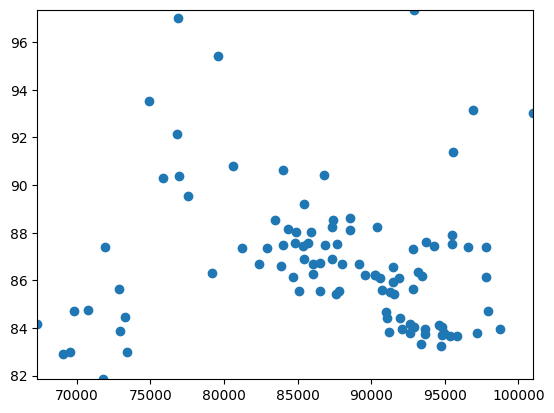

Geração 2
The Pareto is in convergence state for 0 generations


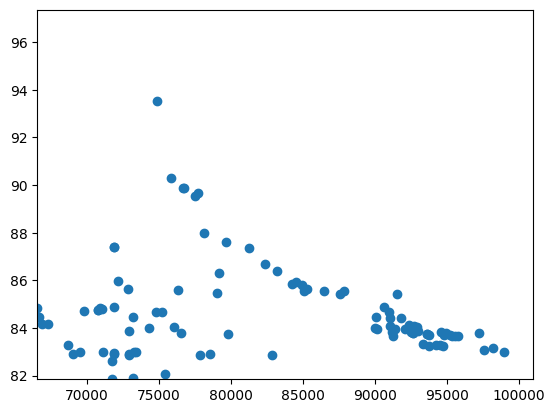

Geração 3
The Pareto is in convergence state for 0 generations


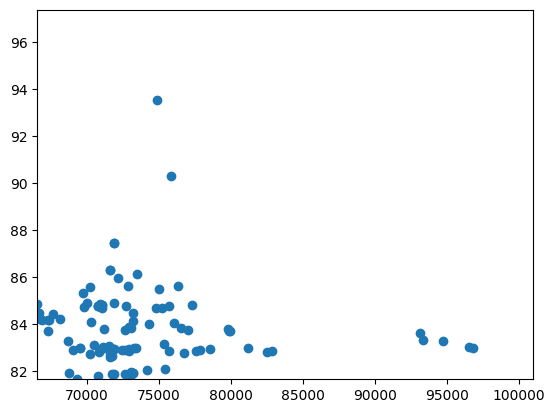

Geração 4
The Pareto is in convergence state for 0 generations


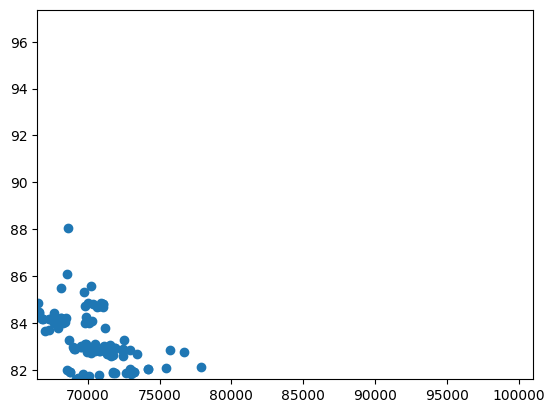

Geração 5
The Pareto is in convergence state for 0 generations


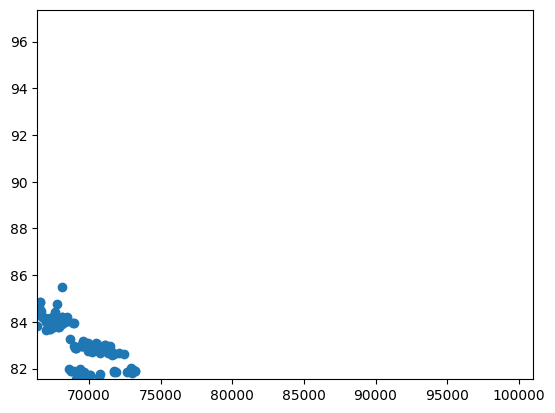

Geração 6
The Pareto is in convergence state for 0 generations


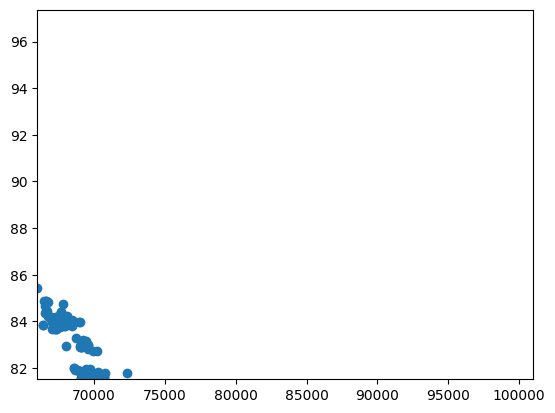

Geração 7
The Pareto is in convergence state for 0 generations


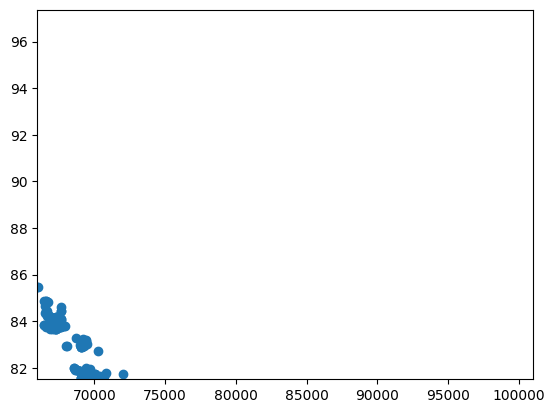

Geração 8
The Pareto is in convergence state for 0 generations


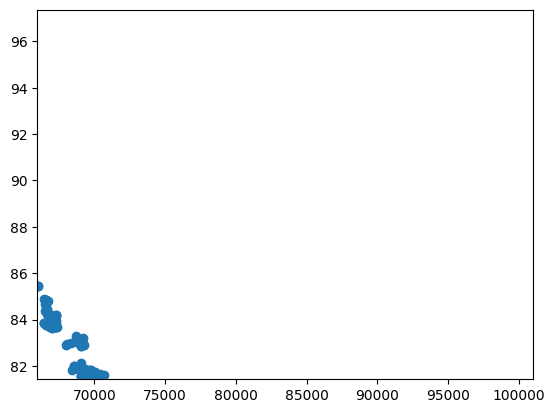

Geração 9
The Pareto is in convergence state for 1 generations


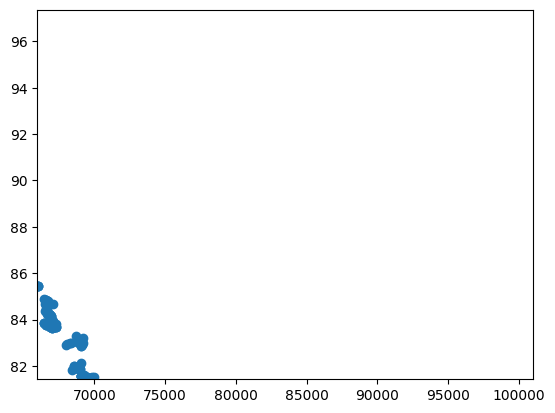

Geração 10
The Pareto is in convergence state for 2 generations


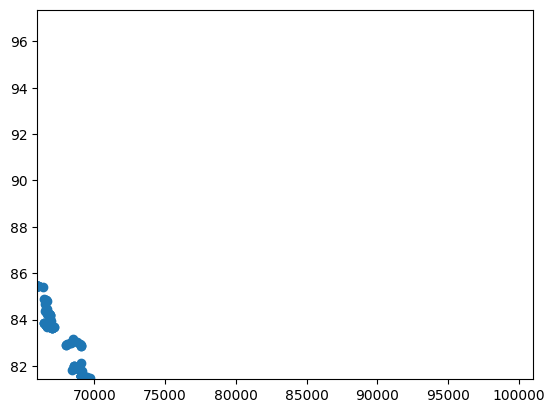

Geração 11
The Pareto is in convergence state for 3 generations


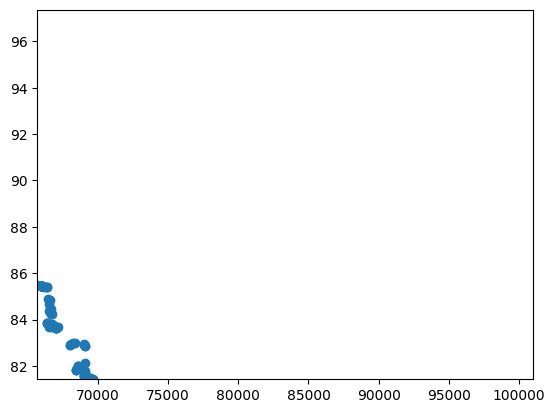

Geração 12
The Pareto is in convergence state for 4 generations


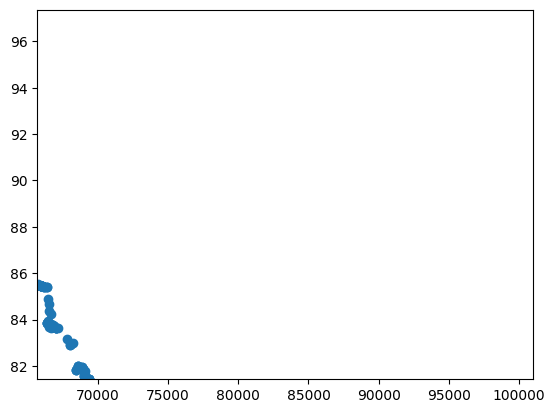

Geração 13
The Pareto is in convergence state for 5 generations


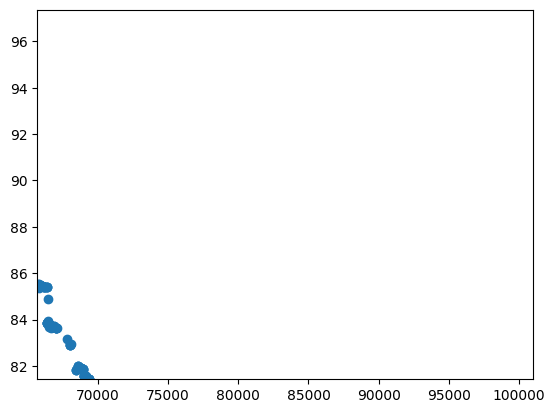

Geração 14
The Pareto is in convergence state for 6 generations


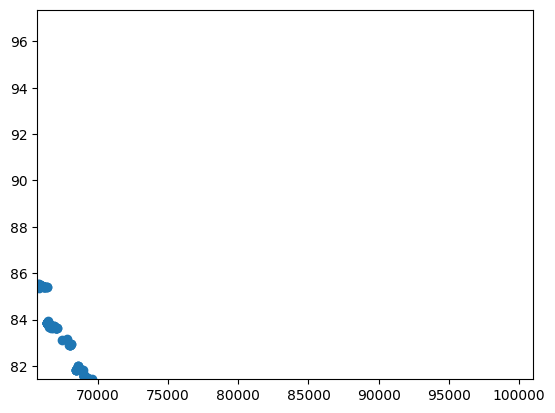

Geração 15
The Pareto is in convergence state for 7 generations


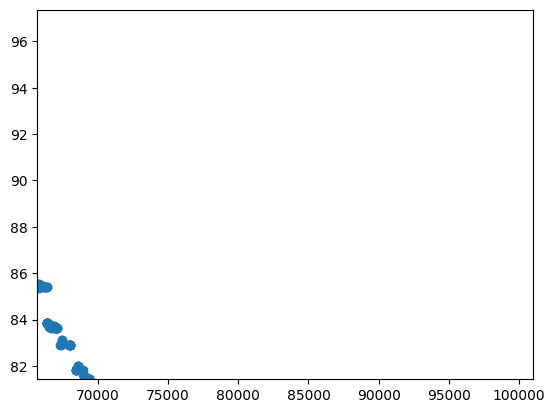

Geração 16
The Pareto is in convergence state for 8 generations


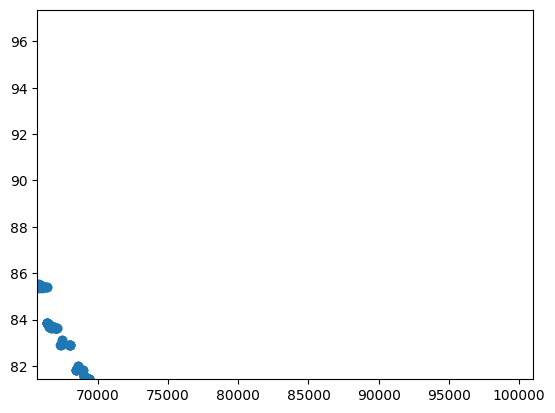

Geração 17
The Pareto is in convergence state for 9 generations


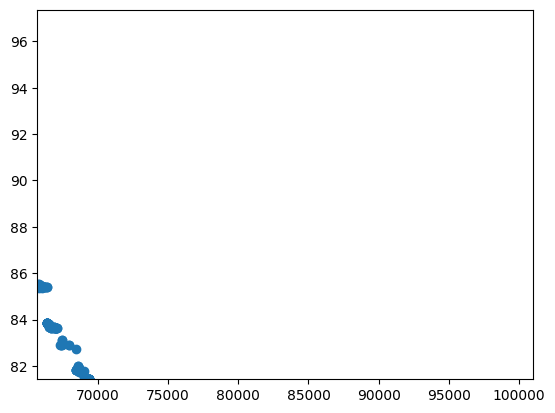

Geração 18
The Pareto is in convergence state for 10 generations


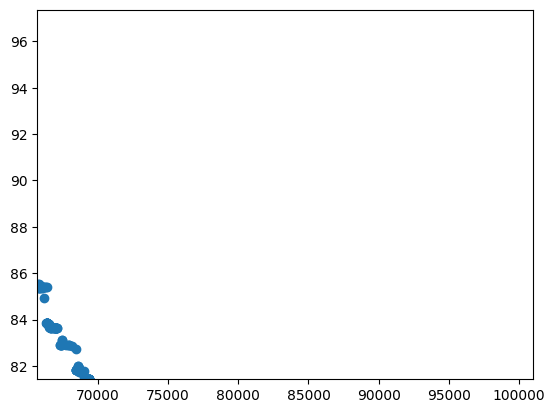

Geração 19
The Pareto is in convergence state for 11 generations


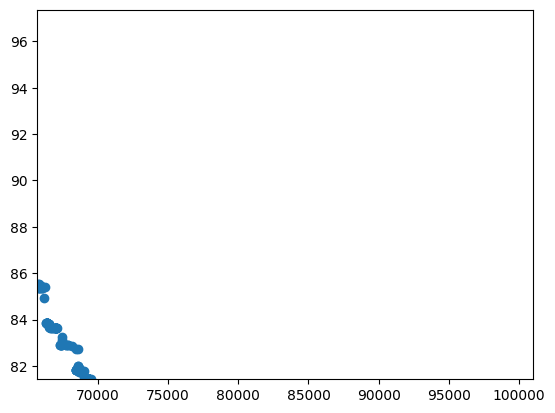

Geração 20
The Pareto is in convergence state for 12 generations


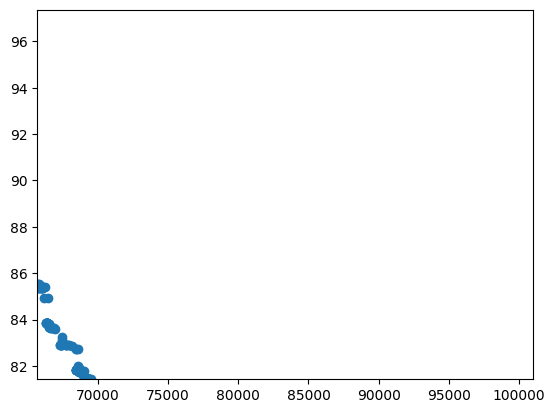

Geração 21
The Pareto is in convergence state for 13 generations


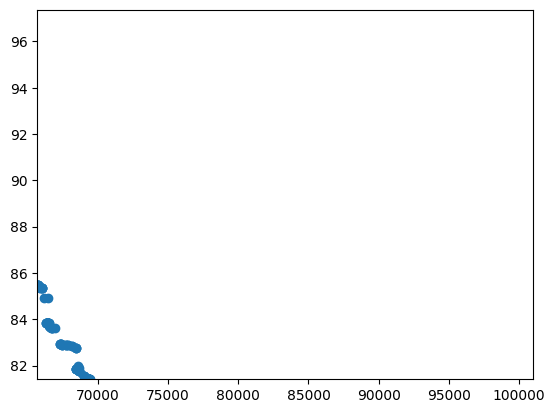

Geração 22
The Pareto is in convergence state for 14 generations


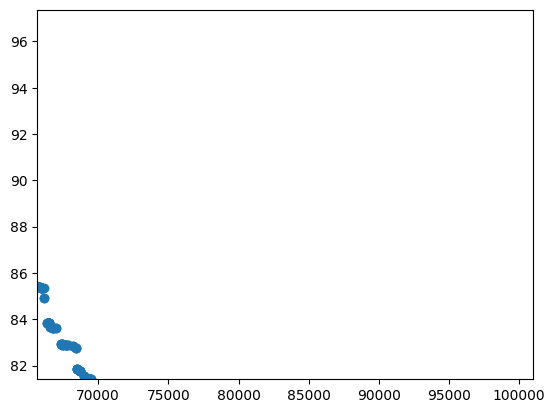

Geração 23
The Pareto is in convergence state for 15 generations


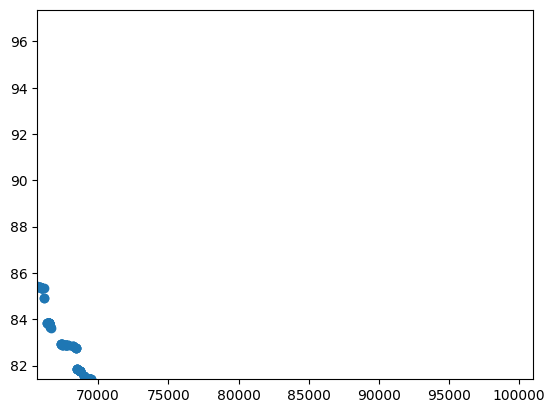

In [6]:
OptimizationObject = optimization_NSGA2.NSGA2_v2(n_ind = 100, mut_rate = 0.3, t_size = 5, DecimalPoints = 4, convergence = 15, ma_len = 1, ma_tol = 0.001)
OptimizationObject.set_functions(Evaluation, Validation)
OptimizationObject.set_population_limits({"Croot": [0.02, 0.3], "Cmax": [0.02, 0.4], "Smax": [0.0001, 0.9999], "Ctip": [0.02, 0.4], "Pitch": [0.1*Diameter_m, 2*Diameter_m], "Collective": [0, 30]})
OptimizationObject.run()

187


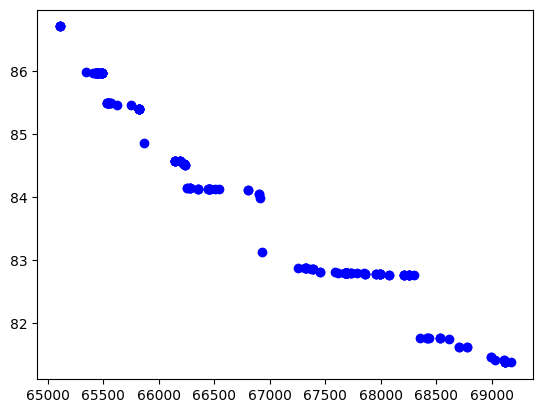

In [5]:
MinOASPL = math.inf
MinPower = math.inf
i = 0
for individual in optimization_NSGA2.return_pareto_front(OptimizationObject.current_pop):
    funcs = individual.get_ObjVal()
    if funcs[0] < MinPower:
        MinPower = funcs[0]
        MinPowerIndividual = individual
    if funcs[1] < MinOASPL:
        MinOASPL = funcs[1]
        MinOASPLIndividual = individual
    plt.plot(funcs[0], funcs[1], 'bo')
    i += 1
print(i)
plt.show()

Pitch: 5.2576
Collective: 28.2834
Pitch: 4.0567
Collective: 24.7134


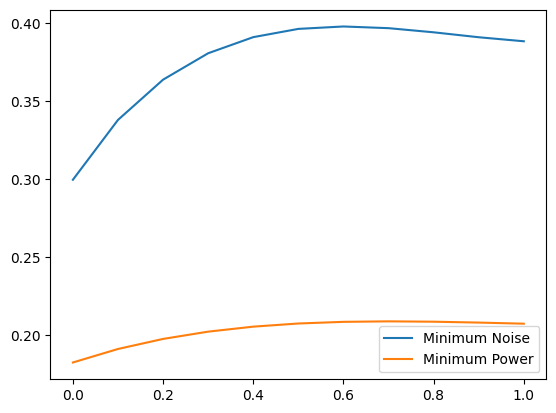

In [6]:
S = np.linspace(0, 1, NumberOfStations, endpoint = True)

Chromossome = MinOASPLIndividual.get_chrom()
Croot_adim = Chromossome["Croot"]
Cmax_adim = Chromossome["Cmax"]
Smax_adim = Chromossome["Smax"]
Ctip_adim = Chromossome["Ctip"]
Pitch_m = Chromossome["Pitch"]
Colective_deg = Chromossome["Collective"]
#c_R = (a*r**3 + b*r**2 + c*r + d)**0.5
a = -(2*Cmax_adim**2*Smax_adim - Cmax_adim**2 + Croot_adim**2*Smax_adim**2 - 2*Croot_adim**2*Smax_adim + Croot_adim**2 - Ctip_adim**2*Smax_adim**2)/(Smax_adim**2*(Smax_adim - 1)**2)
b = -(- 3*Cmax_adim**2*Smax_adim**2 + Cmax_adim**2 - 2*Croot_adim**2*Smax_adim**3 + 3*Croot_adim**2*Smax_adim**2 - Croot_adim**2 + 2*Ctip_adim**2*Smax_adim**3)/(Smax_adim**2*(Smax_adim - 1)**2)
c = -(3*Cmax_adim**2*Smax_adim - 2*Cmax_adim**2 + Croot_adim**2*Smax_adim**3 - 3*Croot_adim**2*Smax_adim + 2*Croot_adim**2 - Ctip_adim**2*Smax_adim**3)/(Smax_adim*(Smax_adim - 1)**2)
d = Croot_adim**2
plt.plot(S, [(a*s**3 + b*s**2 + c*s + d)**0.5 for s in S], label = "Minimum Noise")
print(f'Pitch: {Pitch_m}\nCollective: {Colective_deg}')

Chromossome = MinPowerIndividual.get_chrom()
Croot_adim = Chromossome["Croot"]
Cmax_adim = Chromossome["Cmax"]
Smax_adim = Chromossome["Smax"]
Ctip_adim = Chromossome["Ctip"]
Pitch_m = Chromossome["Pitch"]
Colective_deg = Chromossome["Collective"]
#c_R = (a*r**3 + b*r**2 + c*r + d)**0.5
a = -(2*Cmax_adim**2*Smax_adim - Cmax_adim**2 + Croot_adim**2*Smax_adim**2 - 2*Croot_adim**2*Smax_adim + Croot_adim**2 - Ctip_adim**2*Smax_adim**2)/(Smax_adim**2*(Smax_adim - 1)**2)
b = -(- 3*Cmax_adim**2*Smax_adim**2 + Cmax_adim**2 - 2*Croot_adim**2*Smax_adim**3 + 3*Croot_adim**2*Smax_adim**2 - Croot_adim**2 + 2*Ctip_adim**2*Smax_adim**3)/(Smax_adim**2*(Smax_adim - 1)**2)
c = -(3*Cmax_adim**2*Smax_adim - 2*Cmax_adim**2 + Croot_adim**2*Smax_adim**3 - 3*Croot_adim**2*Smax_adim + 2*Croot_adim**2 - Ctip_adim**2*Smax_adim**3)/(Smax_adim*(Smax_adim - 1)**2)
d = Croot_adim**2
plt.plot(S, [(a*s**3 + b*s**2 + c*s + d)**0.5 for s in S], label = "Minimum Power")
print(f'Pitch: {Pitch_m}\nCollective: {Colective_deg}')
plt.legend()
plt.show()

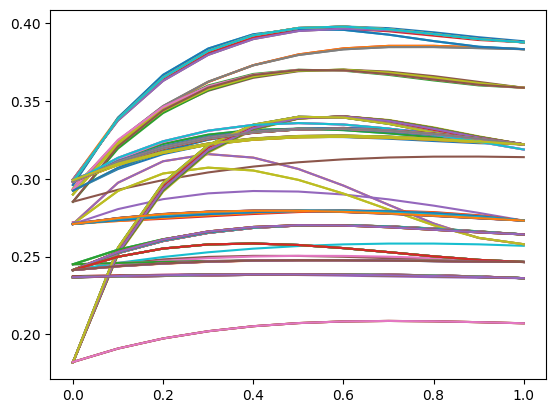

In [7]:
for individual in optimization_NSGA2.return_pareto_front(OptimizationObject.current_pop):
    Chromossome = individual.get_chrom()
    Croot_adim = Chromossome["Croot"]
    Cmax_adim = Chromossome["Cmax"]
    Smax_adim = Chromossome["Smax"]
    Ctip_adim = Chromossome["Ctip"]
    Pitch_m = Chromossome["Pitch"]
    Colective_deg = Chromossome["Collective"]
    #c_R = (a*r**3 + b*r**2 + c*r + d)**0.5
    a = -(2*Cmax_adim**2*Smax_adim - Cmax_adim**2 + Croot_adim**2*Smax_adim**2 - 2*Croot_adim**2*Smax_adim + Croot_adim**2 - Ctip_adim**2*Smax_adim**2)/(Smax_adim**2*(Smax_adim - 1)**2)
    b = -(- 3*Cmax_adim**2*Smax_adim**2 + Cmax_adim**2 - 2*Croot_adim**2*Smax_adim**3 + 3*Croot_adim**2*Smax_adim**2 - Croot_adim**2 + 2*Ctip_adim**2*Smax_adim**3)/(Smax_adim**2*(Smax_adim - 1)**2)
    c = -(3*Cmax_adim**2*Smax_adim - 2*Cmax_adim**2 + Croot_adim**2*Smax_adim**3 - 3*Croot_adim**2*Smax_adim + 2*Croot_adim**2 - Ctip_adim**2*Smax_adim**3)/(Smax_adim*(Smax_adim - 1)**2)
    d = Croot_adim**2
    plt.plot(S, [(a*s**3 + b*s**2 + c*s + d)**0.5 for s in S])
plt.show()